In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
TRAINING_DIR = '/home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/PROCESSING/processed_all/training'
VALIDATION_DIR = '/home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/PROCESSING/processed_all/validation'
TESTING_DIR = '/home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/PROCESSING/processed_all/testing' 

In [4]:
datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=20,
        width_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [5]:
learning_rate = 0.001
epoch = 100
batch_size = 64

In [6]:
char_name = 'CUSTOM_64'

char = os.path.join('/home/rajarshi/Documents/DATASETS/Others/ISL/FINAL', char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    shutil.rmtree(char)
    os.mkdir(char)

In [7]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [8]:
callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 3, verbose=1, mode = 'min', restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = 'loss', verbose=1, save_best_only=True, save_weights_only=False, mode = 'min' , period=1)]

In [9]:
def Custom_Model():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")
    
    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = (32,32,3), activation = activation))
        model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(dense, activation=activation))
#     model.add(Dropout(dropout))
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [10]:
output_activation = 'softmax'
losses = 'categorical_crossentropy'
class_mode = 'categorical'
output_layer = 59

In [11]:
optimizer = keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
# optimizer = keras.optimizers.RMSprop(learning_rate, rho = 0.9)
# optimizer = keras.optimizers.SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)
# optimizer = keras.optimizers.Adagrad(learning_rate)

In [12]:
train_datagen = datagen
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = (32,32),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              target_size = (32,32),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  target_size = (32,32),
                                                  shuffle=True)

Found 62187 images belonging to 59 classes.
Found 20713 images belonging to 59 classes.
Found 20713 images belonging to 59 classes.


In [13]:
dense = 128
activation = 'relu'
dropout = 20
dropout = dropout/100

layer = 4
conv_layer = 1
conv = 16
conv_size = 3

In [14]:
model = Custom_Model()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON A COMPLEX CUSTOM MODEL:-
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D) 

In [15]:
with tf.device("/GPU:0"):
    start = time.time()
    history = model.fit_generator(train_generator,
                                        epochs = epoch,
                                        verbose = 1,
                                        callbacks = callback,
                                        validation_data = validation_generator,
                                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
972/972 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.7120 - precision: 0.8640 - recall: 0.6316 - true_positives: 39275.0000 - true_negatives: 3600664.0000 - false_positives: 6182.0000 - false_negatives: 22912.0000
Epoch 00001: loss improved from inf to 0.91745, saving model to /home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/CUSTOM_64/best_model.h5
972/972 [==============================] - 53s 54ms/step - loss: 0.9175 - accuracy: 0.7120 - precision: 0.8640 - recall: 0.6316 - true_positives: 39275.0000 - true_negatives: 3600664.0000 - false_positives: 6182.0000 - false_negatives: 22912.0000 - val_loss: 0.1313 - val_accuracy: 0.9563 - val_precision: 0.9631 - val_recall: 0.9467 - val_true_positives: 19610.0000 - val_true_negatives: 1200603.0000 - val_false_positives: 751.0000 - val_false_negatives: 1103.0


Epoch 00010: LearningRateScheduler reducing learning rate to 0.001.
Epoch 10/100
971/972 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9861 - precision: 0.9871 - recall: 0.9851 - true_positives: 61199.0000 - true_negatives: 3602335.0000 - false_positives: 799.0000 - false_negatives: 924.0000  ETA: 10s - loss: 0.0432 - accuracy: 0.9860 - pre
Epoch 00010: loss improved from 0.04290 to 0.04247, saving model to /home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/CUSTOM_64/best_model.h5
972/972 [==============================] - 57s 59ms/step - loss: 0.0425 - accuracy: 0.9861 - precision: 0.9871 - recall: 0.9851 - true_positives: 61263.0000 - true_negatives: 3606047.0000 - false_positives: 799.0000 - false_negatives: 924.0000 - val_loss: 0.0159 - val_accuracy: 0.9946 - val_precision: 0.9948 - val_recall: 0.9946 - val_true_positives: 20601.0000 - val_true_negatives: 1201246.0000 - val_false_positives: 108.0000 - val_false_negatives: 112.0000

Epoch 00011: LearningRa


Epoch 00019: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 19/100
972/972 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9979 - precision: 0.9980 - recall: 0.9978 - true_positives: 62049.0000 - true_negatives: 3606719.0000 - false_positives: 127.0000 - false_negatives: 138.0000
Epoch 00019: loss improved from 0.00720 to 0.00680, saving model to /home/rajarshi/Documents/DATASETS/Others/ISL/FINAL/CUSTOM_64/best_model.h5
972/972 [==============================] - 59s 60ms/step - loss: 0.0068 - accuracy: 0.9979 - precision: 0.9980 - recall: 0.9978 - true_positives: 62049.0000 - true_negatives: 3606719.0000 - false_positives: 127.0000 - false_negatives: 138.0000 - val_loss: 0.0010 - val_accuracy: 0.9996 - val_precision: 0.9996 - val_recall: 0.9996 - val_true_positives: 20705.0000 - val_true_negatives: 1201346.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2

In [16]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 1109.445072889328 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


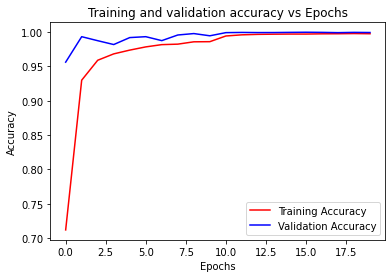

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


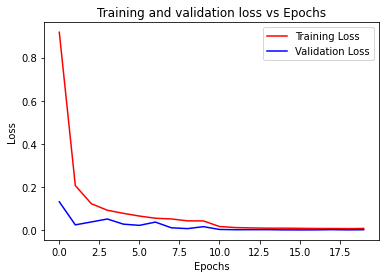

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "accuracy.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
loss_fig_name = "loss.eps"

plt.savefig(os.path.join(char, loss_fig_name))
plt.show()

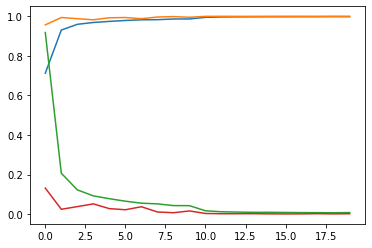

In [28]:
plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)

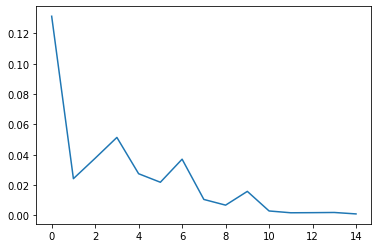

In [19]:
plt.plot(val_loss[:15])

In [20]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 99.72823858261108 %
The validation accuracy is: 99.96137619018555 %
The test accuracy is: 99.93723630905151 %


In [21]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [22]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 99.93723630905151
Test Precision: 99.93723630905151
Test Recall: 99.93723630905151
True Positive: 20700
Test Negetive: 1201341
False Positive: 13
False Negetive: 13
Sensitivity: 99.93723748370589
Specificity: 99.9989178876501


In [23]:
test_class_list = []
for test_name in os.listdir(TESTING_DIR):
    test = os.path.join(TESTING_DIR,test_name)
    test_class_list.append(test)
test_class_list.sort()

In [24]:
def max_pred(pred):
    pred_categorical = keras.utils.to_categorical(pred)
    if 59 > 2:
        pred_max = np.argmax(pred)
    else:
        pred_max = np.argmax(pred_categorical)
    return pred_max

In [25]:
y_true = test_generator.classes
labels = validation_generator.class_indices

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_pred = []
for i in range(59):
    for filename in os.listdir(test_class_list[i]):
        file = os.path.join(test_class_list[i], filename)
        img = image.load_img(file, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])

        pred = model.predict(images, batch_size = batch_size)
        pred_max = max_pred(pred)
        
        y_pred.append(pred_max)
 
print("Calculating CLASSIFICATION REPORT..........:")
classification_report = classification_report(y_true, y_pred, target_names=labels)
print(classification_report)

print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
cm = confusion_matrix(y_true, y_pred)
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("sensitivity = {:.4f}".format(sensitivity))
print("specificity = {:.4f}".format(specificity))

Calculating CLASSIFICATION REPORT..........:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      0.94      0.97       300
           2       0.85      0.93      0.89       300
           3       0.99      1.00      0.99       300
           4       0.97      0.78      0.86       300
           5       0.75      1.00      0.86       300
           6       1.00      0.93      0.96       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
           A       0.78      1.00      0.88       300
      ABOARD       1.00      1.00      1.00       894
       ABOVE       1.00      1.00      1.00       429
      ACROSS       1.00      1.00      1.00       287
     ADVANCE       0.98      1.00      0.99       269
      AFRAID       1.00      1.00      1.00       476
         ALL       1.00      0.78   

In [27]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")



readme.write("\n\n\n--MODEL-PARAMETERS--")


    
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
readme.write("Number of Conv layer = " + str(conv_layer))
readme.write("\nFilter size = " + str(conv_size)+ "*" + str(conv_size) + "\n\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write("\nTest Accuracy = " + str(test_accuracy) + " %")
readme.write("\nTest Precision = " + str(test_precision) + " %")
readme.write("\nTest Recall = " + str(test_recall) + " %")
readme.write("\nTrue Positive = " + str(tp))
readme.write("\nTrue Negetive = " + str(tn))
readme.write("\nFalse Positive = " + str(fp))
readme.write("\nFalse Negetive = " + str(fn))
readme.write("\nSensitivity = " + str(sensitivity))
readme.write("\nSpecificity = " + str(specificity) + " \n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\nacc = " + str(acc))
readme.write("\n\nval_acc = " + str(val_acc))
readme.write("\nloss = " + str(loss))
readme.write("\n\nval_loss = " + str(val_loss))


readme.write("\n\n--Classification Report--\n")
readme.write(classification_report)

readme.write("\nSensitivity = " + str(int(sensitivity*100)) + " %")
readme.write("\nSpecificity = " + str(int(specificity*100)) + " %")


readme.write("\nExecution Time: {} seconds".format(duration))

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
